In [1]:
import os
import pandas as pd
import numpy as np
import ants
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
from DeepCor_utils import correlate_columns

numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.6.1


In [3]:
def get_roi_data(im_fn,roi_fn):
    roi = ants.image_read(roi_fn)
    im = ants.image_read(im_fn)

    roi_data = im.numpy()[roi.numpy()==1].mean()
    return roi_data


In [4]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
print(len(subs))


14


In [5]:
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
analysis_name = 'refactored-forrest-v3'
#analysis_name = 'refac-baseline-forrest-v1'
#analysis_name = 'refac-baseline-TC-forrest-v1'
ofdir = os.path.join(ofdir_root,analysis_name)

In [6]:
rvec=[1,2,3,4]

In [7]:
from DeepCor_utils import get_design_matrix
sub = subs[5]
r = 4
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
epi = ants.image_read(epi_fn.format(sub=sub,r=r))
events_fn = os.path.join(f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv')
X1 = get_design_matrix(epi,events_fn)

In [8]:
#'../Data/StudyForrest/ensembles_last_CVAE/refactored-forrest-v3/signal_S0_R1_avg.nii.gz'
#'../Data/StudyForrest/ensembles_last_CVAE/refactored-forrest-v3/preproc_S0_R1.nii.gz'
#'../Data/StudyForrest/ensembles_last_CVAE/refactored-forrest-v3/compcor_S0_R1.nii.gz'

In [9]:
def zscore(arr):
    newArr = (arr-arr.mean(axis=-1)[:,np.newaxis])/arr.std(axis=-1)[:,np.newaxis]
    newArr[np.isnan(newArr)]=0
    return newArr

In [10]:
ffa_roi_fn_temp = '../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz'
ppa_roi_fn_temp = '../Data/StudyForrest/ROIs/rPPA_final_mask_{sub}_bin.nii.gz'

In [31]:
preproc_series_ffa = np.zeros(156)
preproc_series_ppa = np.zeros(156)
for s in tqdm(range(len(subs))):
    for r in rvec:
        fn = '../Data/StudyForrest/ensembles_last_CVAE/refactored-forrest-v3/preproc_S{s}_R{r}.nii.gz'
        im = ants.image_read(fn.format(s=s,r=r))
        ffa_roi = ants.image_read(ffa_roi_fn_temp.format(sub=subs[s])).numpy()==1
        ppa_roi = ants.image_read(ppa_roi_fn_temp.format(sub=subs[s])).numpy()==1
        #preproc_series_ffa.append(zscore(im.numpy()[ffa_roi]))
        #preproc_series_ppa.append(zscore(im.numpy()[ppa_roi]))
        preproc_series_ffa = np.vstack((preproc_series_ffa,im.numpy()[ffa_roi]))
        preproc_series_ppa = np.vstack((preproc_series_ppa,im.numpy()[ppa_roi]))
preproc_series_ffa=preproc_series_ffa[1::,:]
preproc_series_ppa=preproc_series_ppa[1::,:]

100%|███████████████████████████████████████████| 14/14 [00:39<00:00,  2.84s/it]


In [32]:
compcor_series_ffa = np.zeros(156)
compcor_series_ppa = np.zeros(156)
for s in tqdm(range(len(subs))):
    for r in rvec:
        fn = '../Data/StudyForrest/ensembles_last_CVAE/refactored-forrest-v3/compcor_S{s}_R{r}.nii.gz'
        im = ants.image_read(fn.format(s=s,r=r))
        ffa_roi = ants.image_read(ffa_roi_fn_temp.format(sub=subs[s])).numpy()==1
        ppa_roi = ants.image_read(ppa_roi_fn_temp.format(sub=subs[s])).numpy()==1
        compcor_series_ffa = np.vstack((compcor_series_ffa,im.numpy()[ffa_roi]))
        compcor_series_ppa = np.vstack((compcor_series_ppa,im.numpy()[ppa_roi]))
compcor_series_ffa=compcor_series_ffa[1::,:]
compcor_series_ppa=compcor_series_ppa[1::,:]

100%|███████████████████████████████████████████| 14/14 [00:40<00:00,  2.86s/it]


In [33]:
deepcor_series_ffa = np.zeros(156)
deepcor_series_ppa = np.zeros(156)
for s in tqdm(range(len(subs))):
    for r in rvec:
        fn = '../Data/StudyForrest/ensembles_last_CVAE/refactored-forrest-v3/signal_S{s}_R{r}_avg.nii.gz'
        im = ants.image_read(fn.format(s=s,r=r))
        ffa_roi = ants.image_read(ffa_roi_fn_temp.format(sub=subs[s])).numpy()==1
        ppa_roi = ants.image_read(ppa_roi_fn_temp.format(sub=subs[s])).numpy()==1
        deepcor_series_ffa = np.vstack((deepcor_series_ffa,im.numpy()[ffa_roi]))
        deepcor_series_ppa = np.vstack((deepcor_series_ppa,im.numpy()[ppa_roi]))
deepcor_series_ffa=deepcor_series_ffa[1::,:]
deepcor_series_ppa=deepcor_series_ppa[1::,:]

100%|███████████████████████████████████████████| 14/14 [00:39<00:00,  2.83s/it]


In [34]:
std0 = (preproc_series_ffa.std(axis=-1)<1e-3) + (compcor_series_ffa.std(axis=-1)<1e-3) + (deepcor_series_ffa.std(axis=-1)<1e-3)
preproc_series_ffa=preproc_series_ffa[std0==False,:]
compcor_series_ffa=compcor_series_ffa[std0==False,:]
deepcor_series_ffa=deepcor_series_ffa[std0==False,:]

In [35]:
arr1=zscore(preproc_series_ffa).mean(axis=0)
arr2=zscore(compcor_series_ffa).mean(axis=0)
arr3=zscore(deepcor_series_ffa).mean(axis=0)

In [36]:
reg = X1['face'].values

In [37]:
[np.corrcoef(reg,arr)[0,1] for arr in [arr1,arr2,arr3]]

[0.5841637349374367, 0.6057198554103053, 0.5782595381727405]

In [38]:
regMat =  np.array([X1['face'].values for _ in range(preproc_series_ffa.shape[0])])

In [39]:
r1 = correlate_columns(preproc_series_ffa.transpose(),regMat.transpose())
r2 = correlate_columns(compcor_series_ffa.transpose(),regMat.transpose())
r3 = correlate_columns(deepcor_series_ffa.transpose(),regMat.transpose())

In [40]:
[r1.mean(),r2.mean(),r3.mean()]

[0.15307552093281493, 0.17165243483113038, 0.24715155208269113]

In [42]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

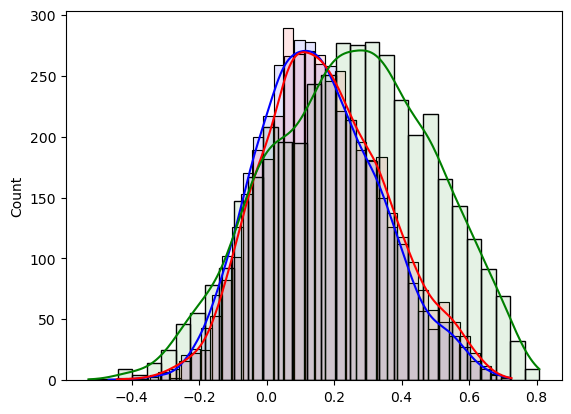

In [43]:
sns.histplot(r1,kde=True,alpha=.1,color='b')
sns.histplot(r2,kde=True,alpha=.1,color='r')
sns.histplot(r3,kde=True,alpha=.1,color='g')

In [ ]:
#np.argsort(r3-r2)[-1]
np.argsort(r3)[-1]

In [63]:
preproc_series_ffa.shape

(4104, 156)

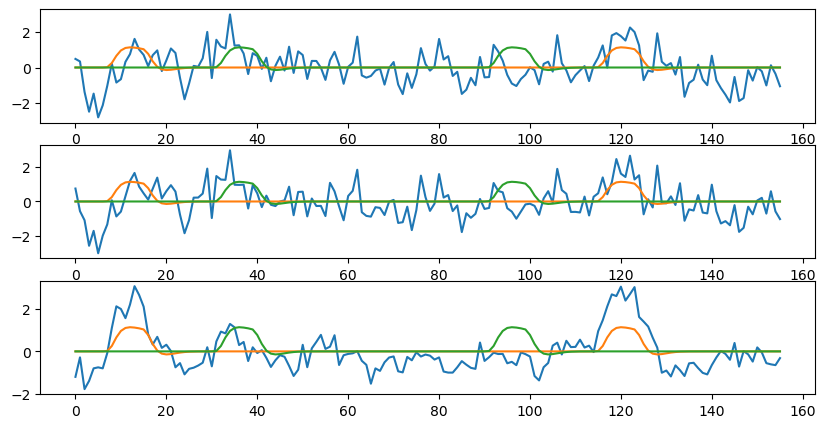

In [44]:
idx = 2586
plt.figure(figsize=(10,5))
plt.subplot(3,1,1);plt.plot(zscore(preproc_series_ffa)[idx,:]);plt.plot(X1['face'].values);plt.plot(X1['body'].values)
plt.subplot(3,1,2);plt.plot(zscore(compcor_series_ffa)[idx,:]);plt.plot(X1['face'].values);plt.plot(X1['body'].values)
plt.subplot(3,1,3);plt.plot(zscore(deepcor_series_ffa)[idx,:]);plt.plot(X1['face'].values);plt.plot(X1['body'].values)

In [80]:
n = zpreproc_series_ffa.shape[0]

In [46]:
zpreproc_series_ffa = zscore(preproc_series_ffa)
zcompcor_series_ffa = zscore(compcor_series_ffa)
zdeepcor_series_ffa = zscore(deepcor_series_ffa)

In [98]:
rpreproc = correlate_columns(zpreproc_series_ffa.transpose(),np.repeat(X1['face'].values[np.newaxis,:],n,0).transpose())
rcompcor = correlate_columns(zcompcor_series_ffa.transpose(),np.repeat(X1['face'].values[np.newaxis,:],n,0).transpose())
rdeepcor = correlate_columns(zdeepcor_series_ffa.transpose(),np.repeat(X1['face'].values[np.newaxis,:],n,0).transpose())

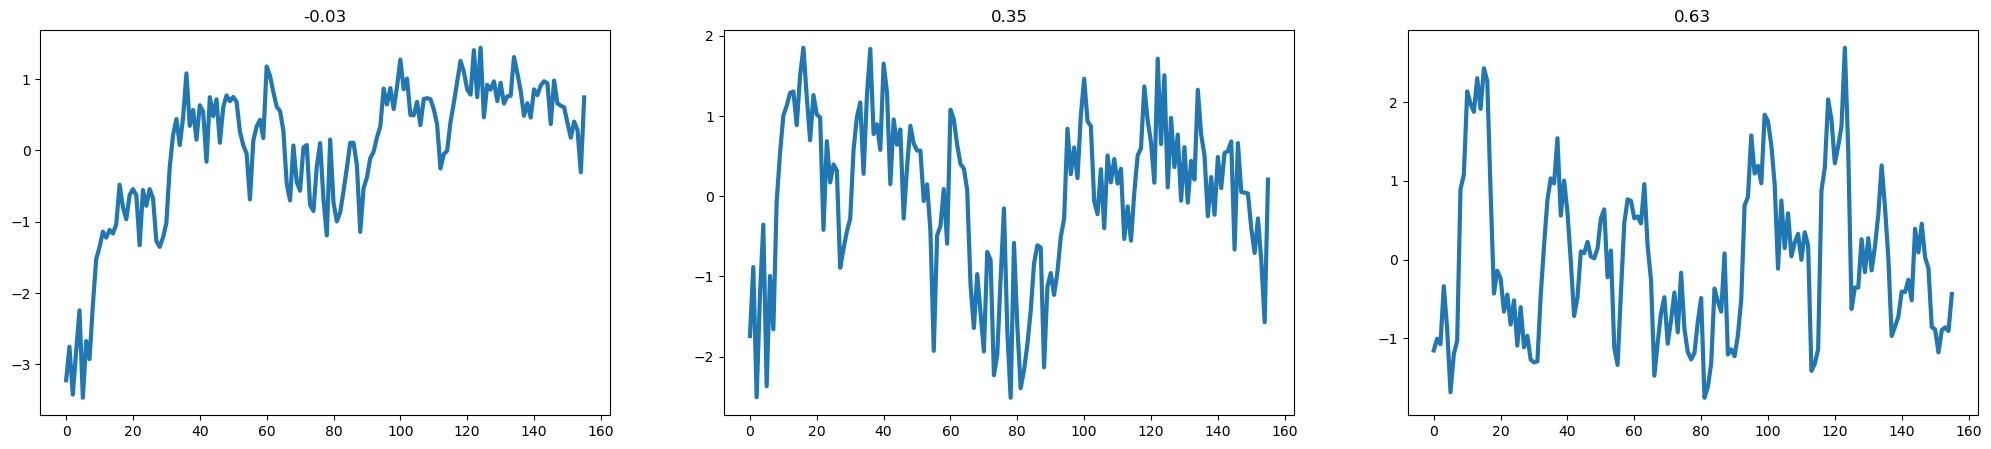

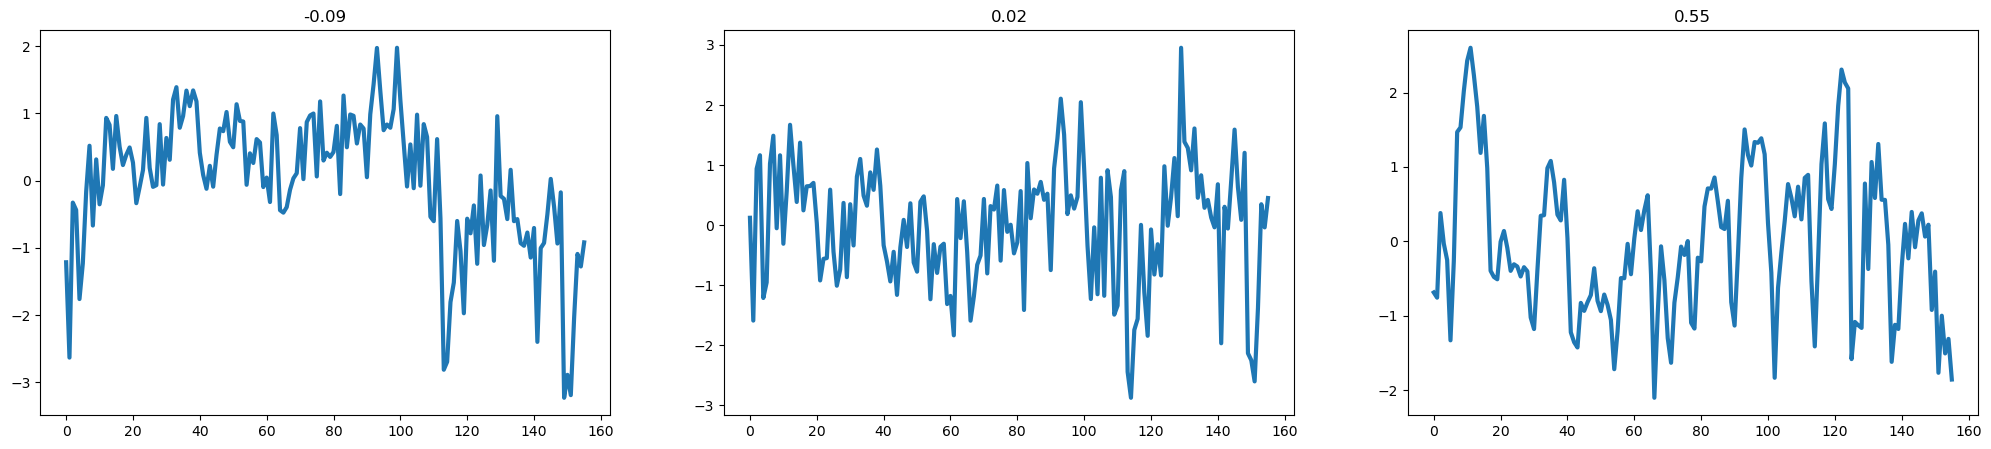

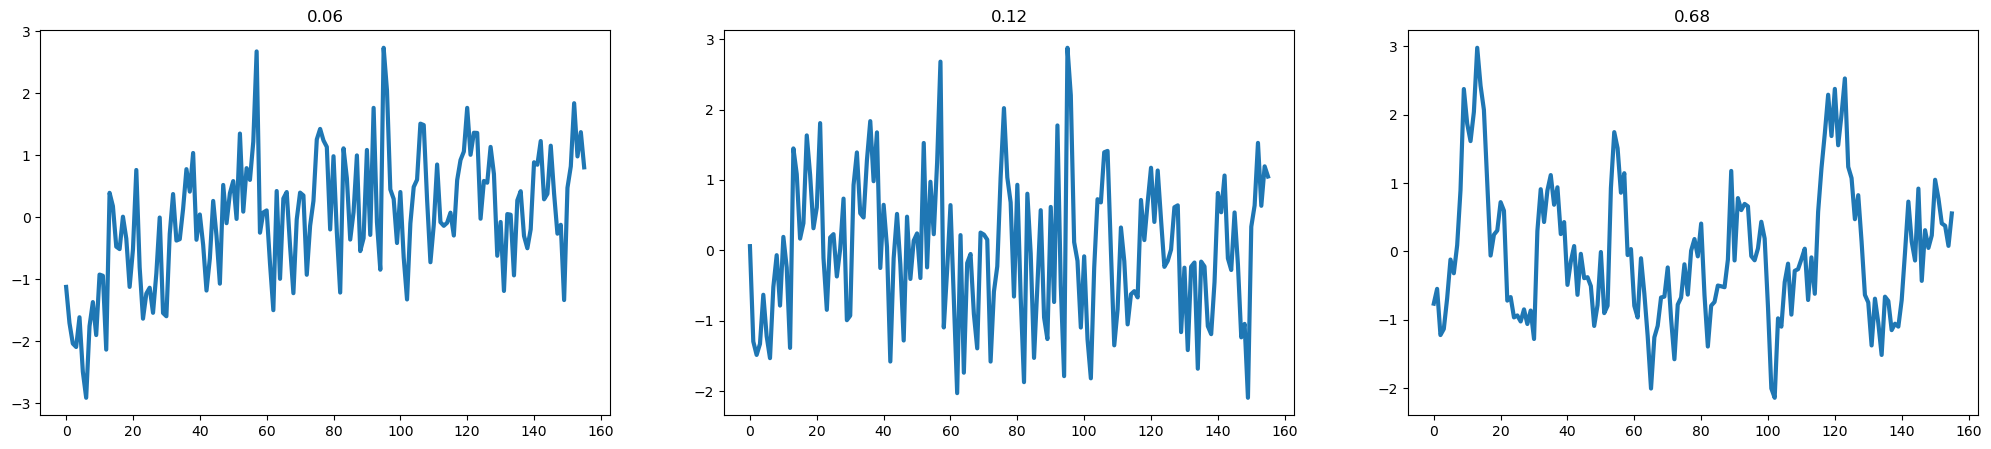

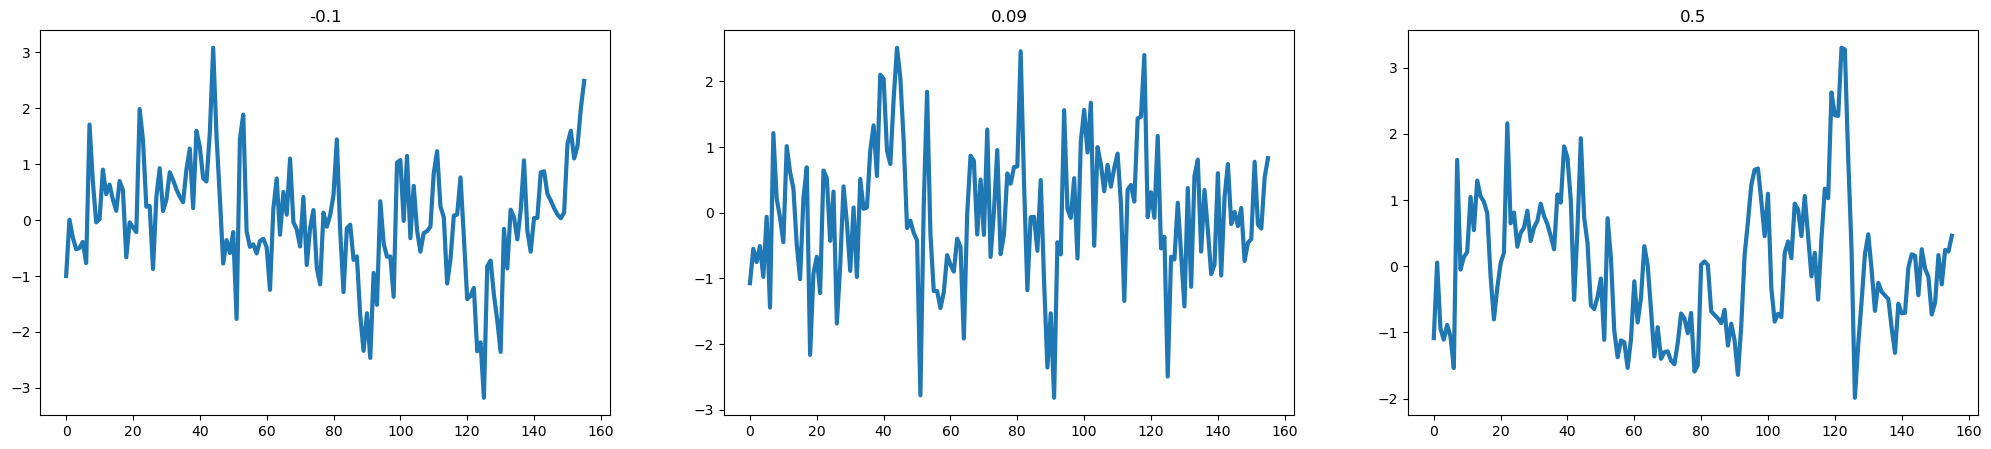

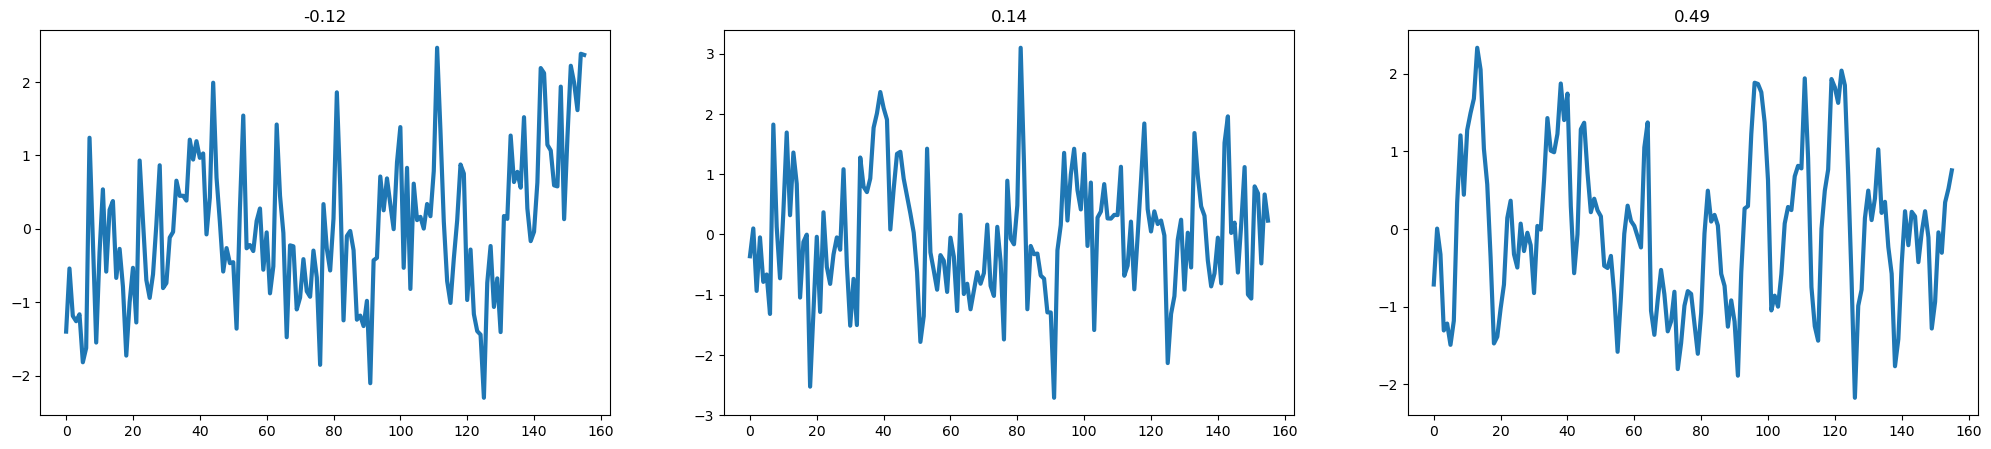

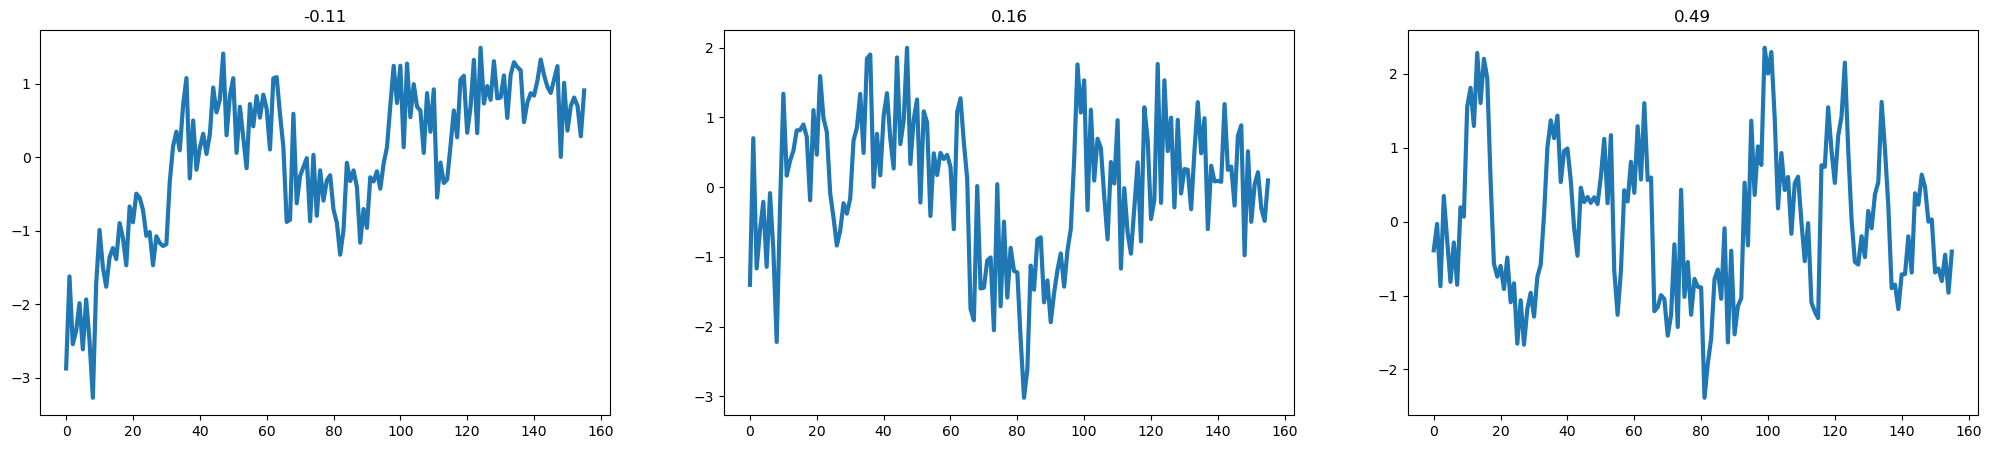

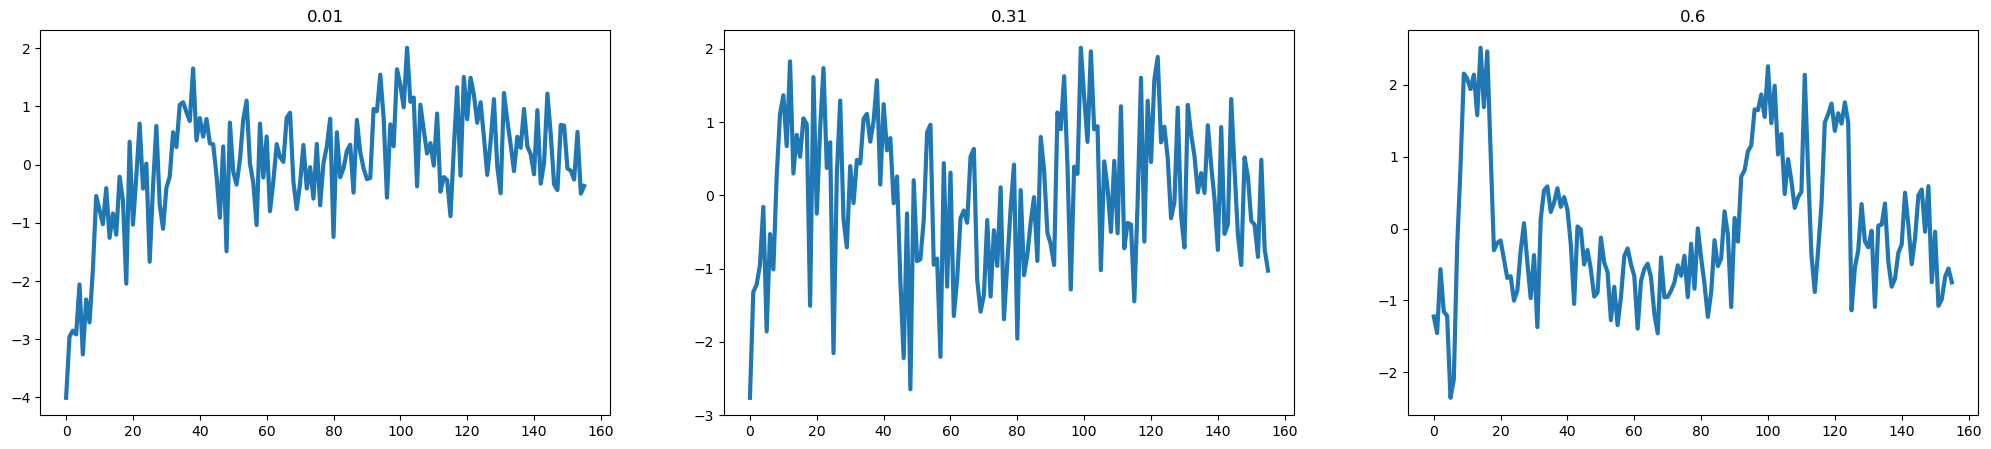

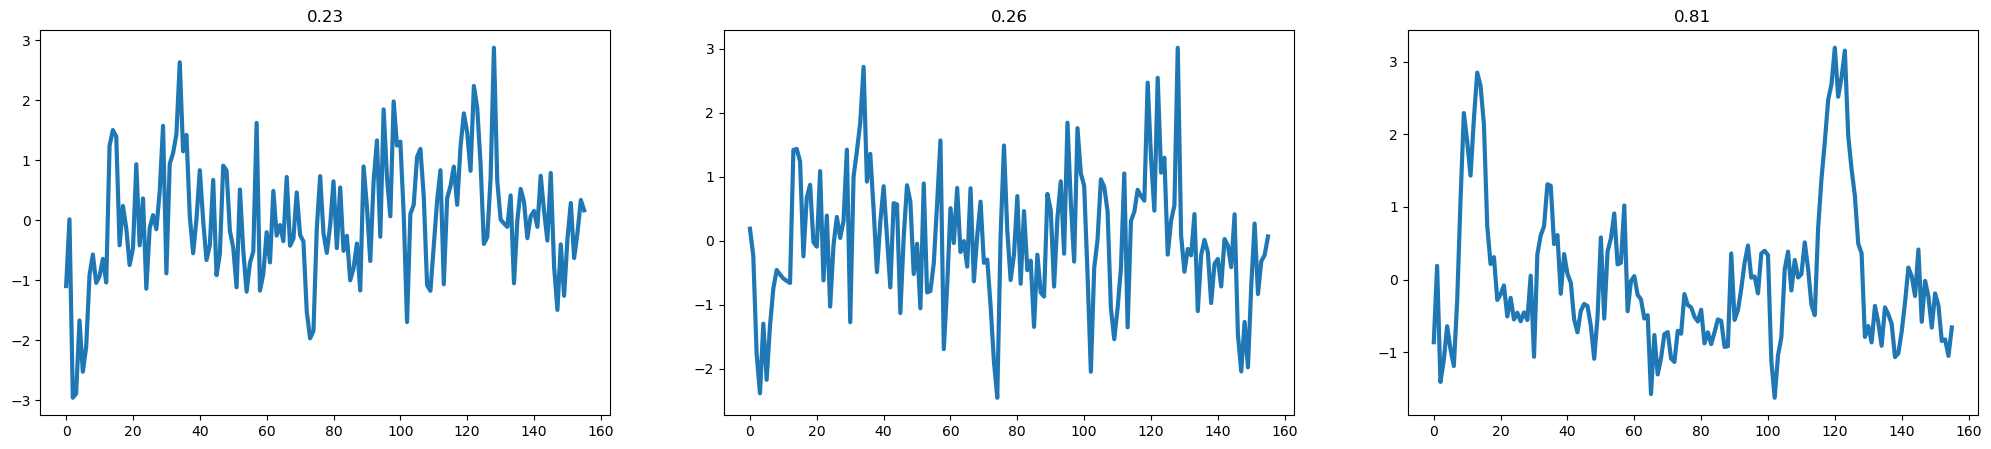

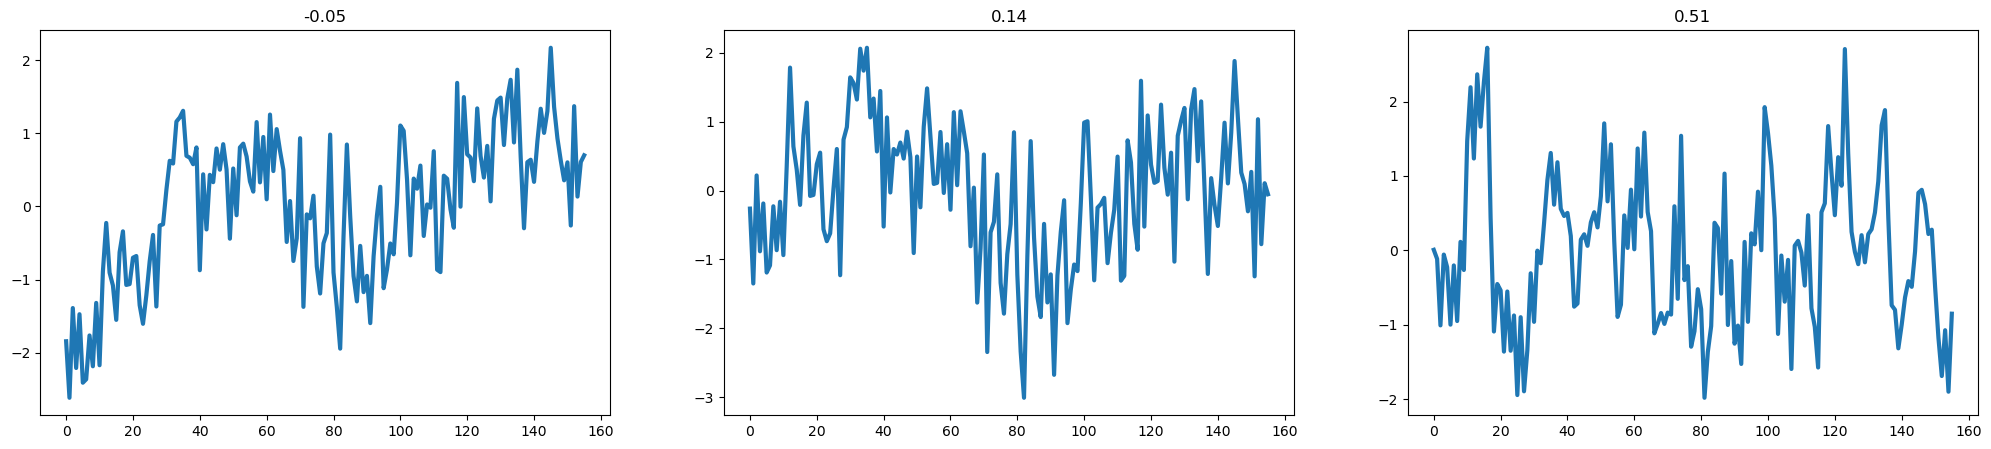

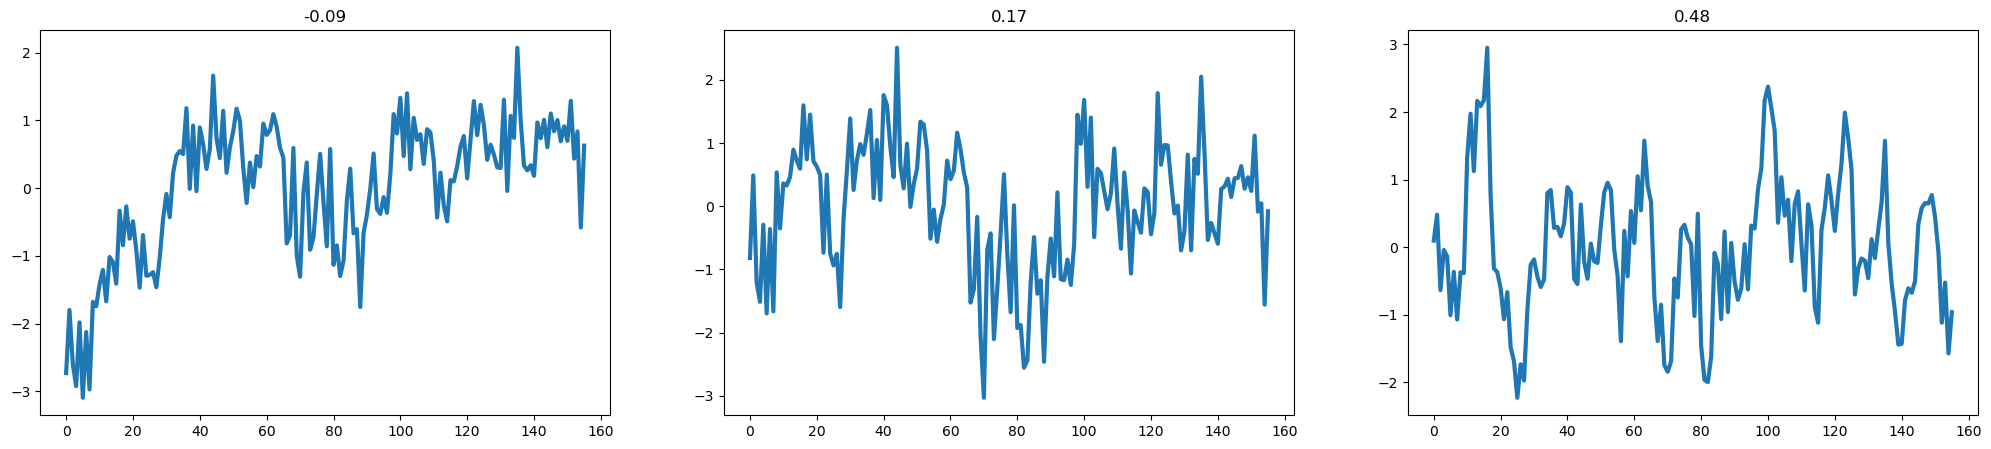

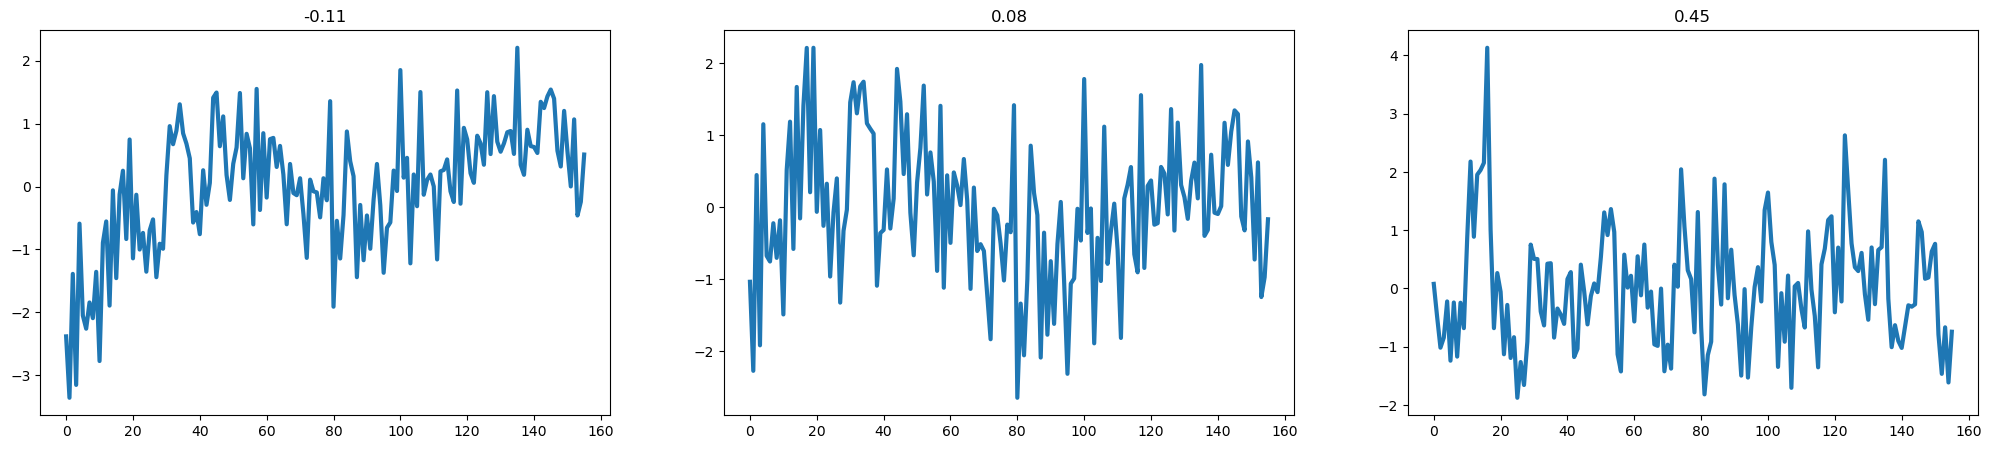

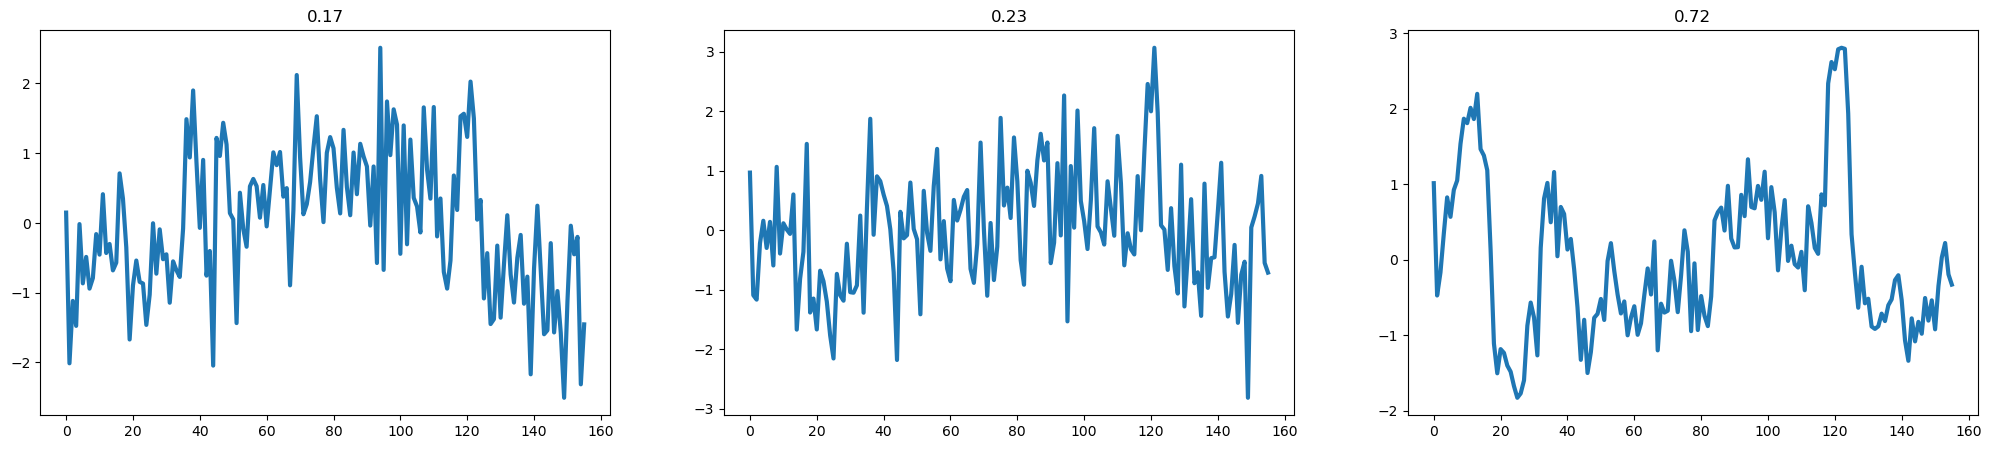

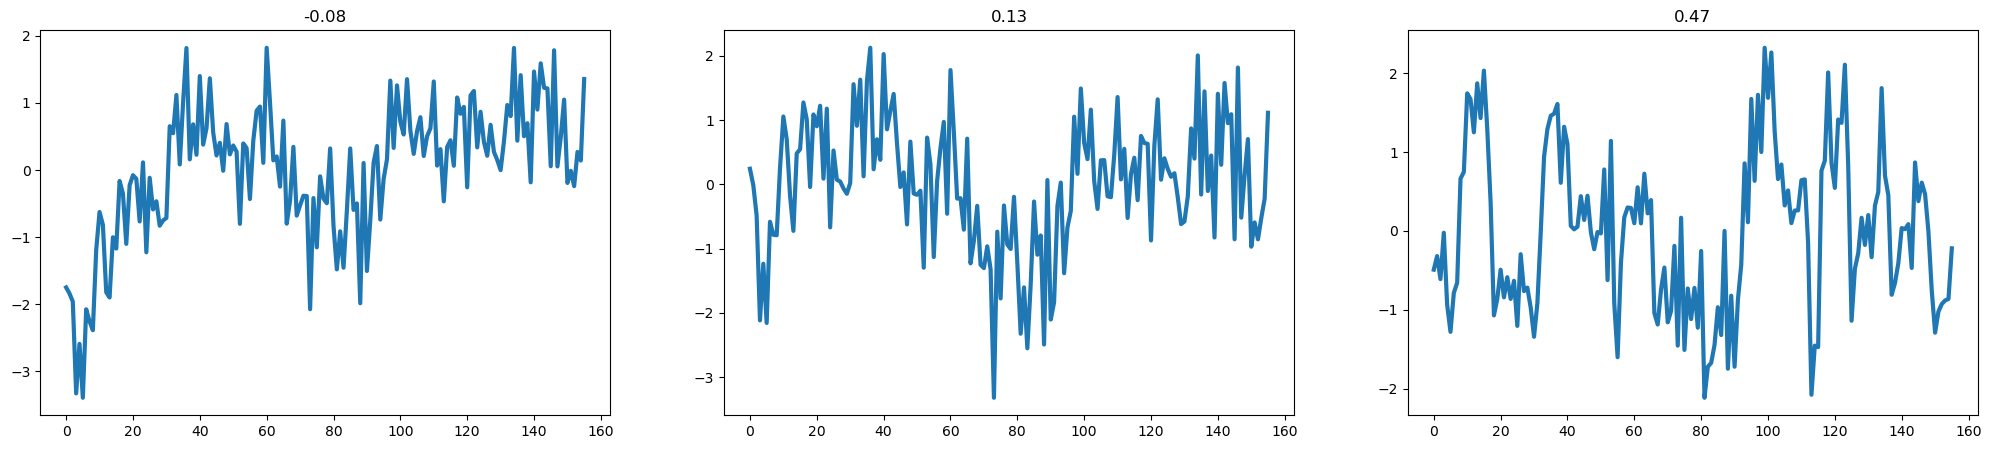

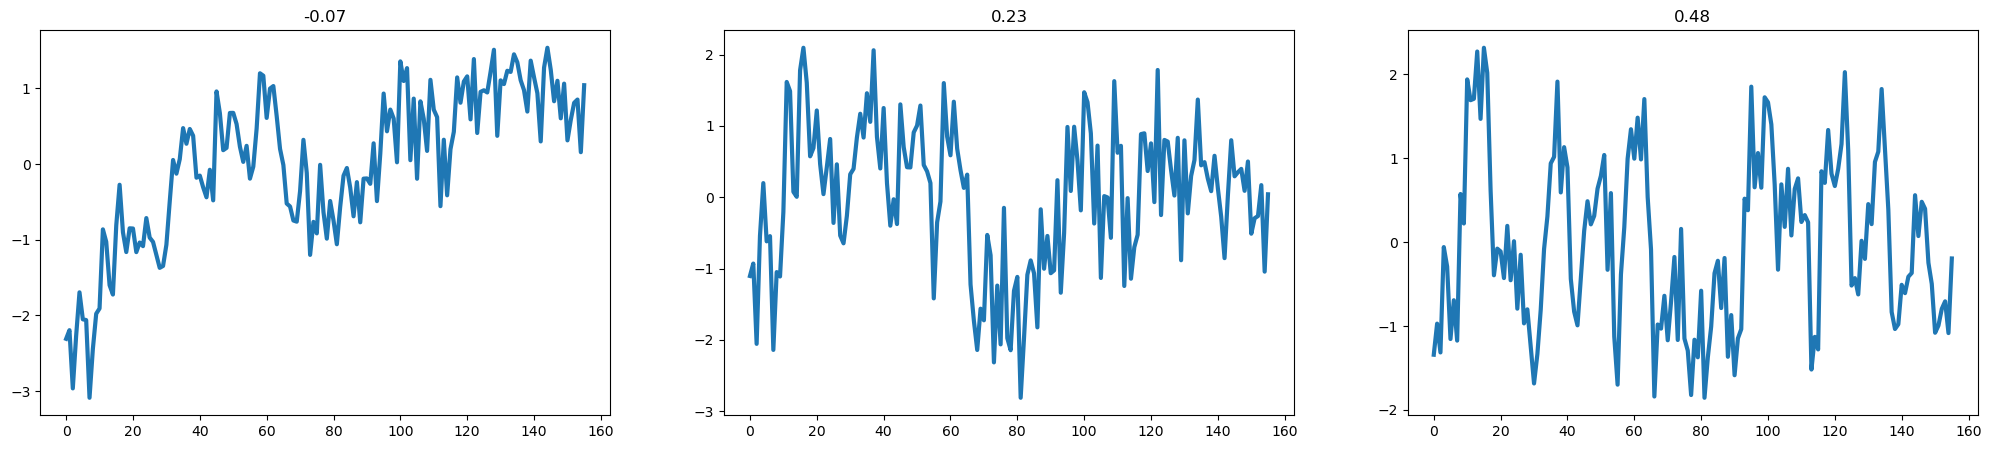

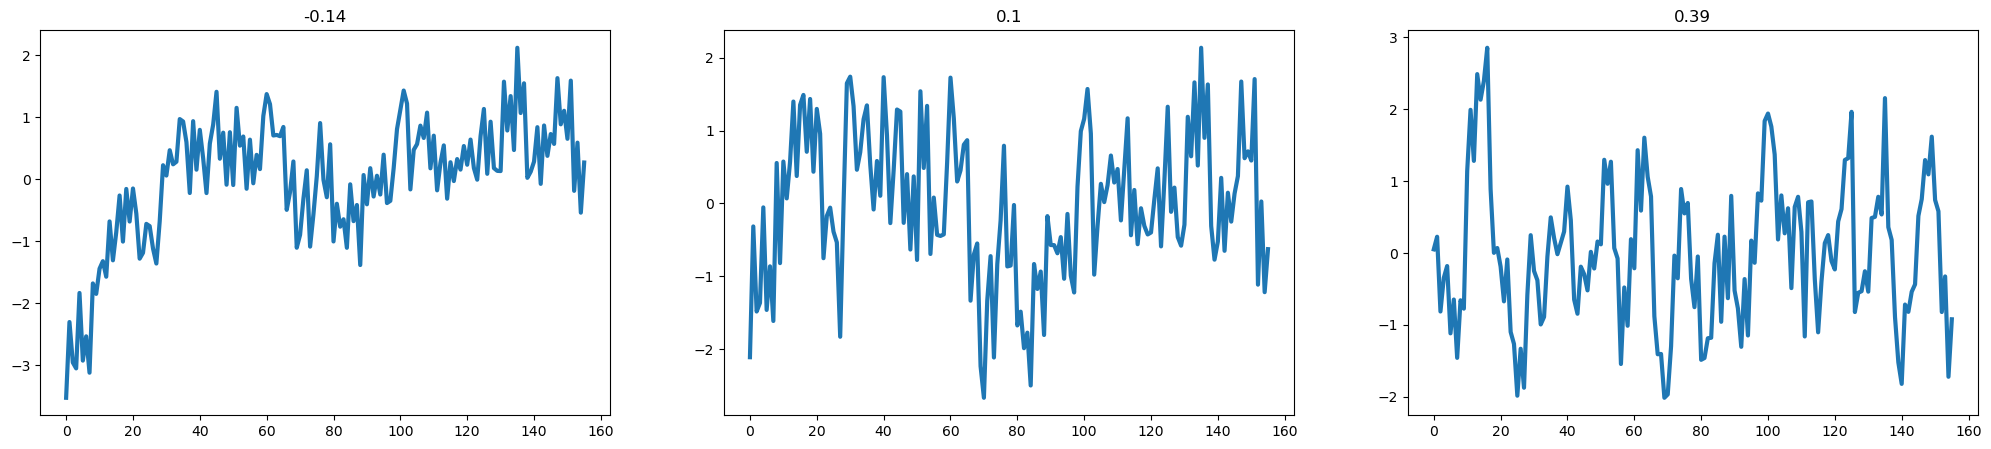

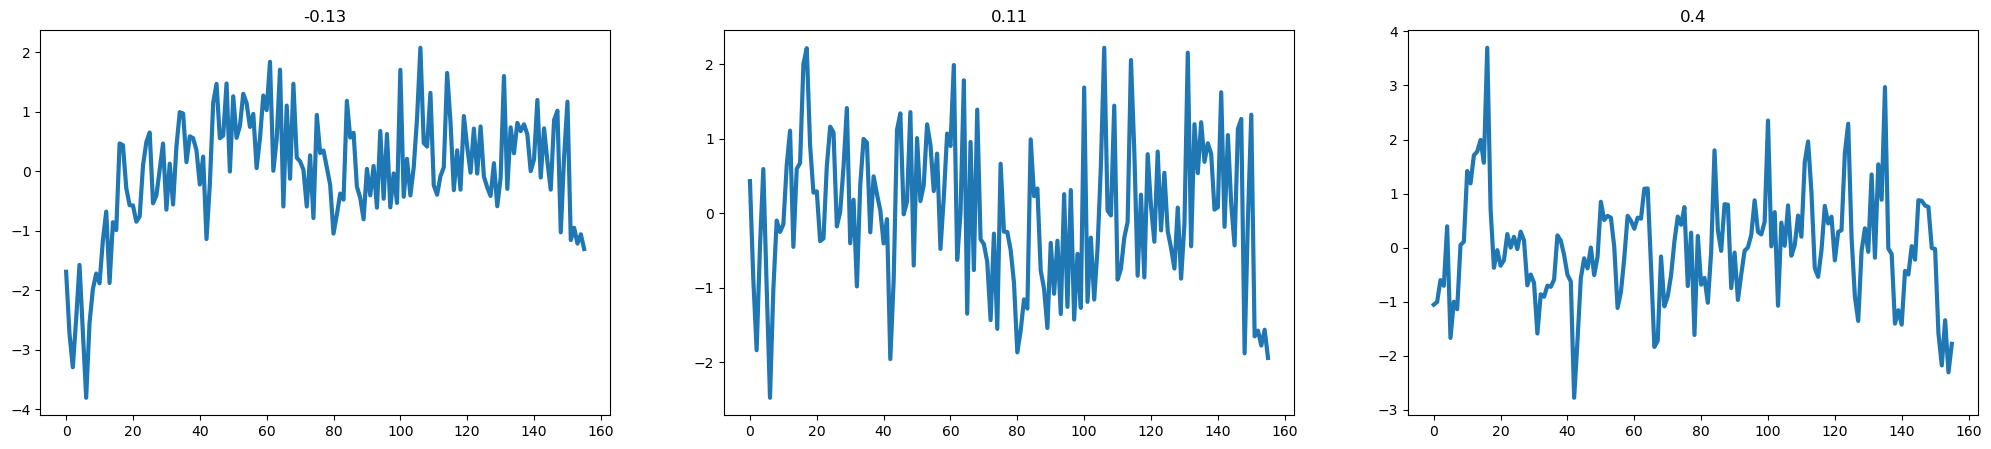

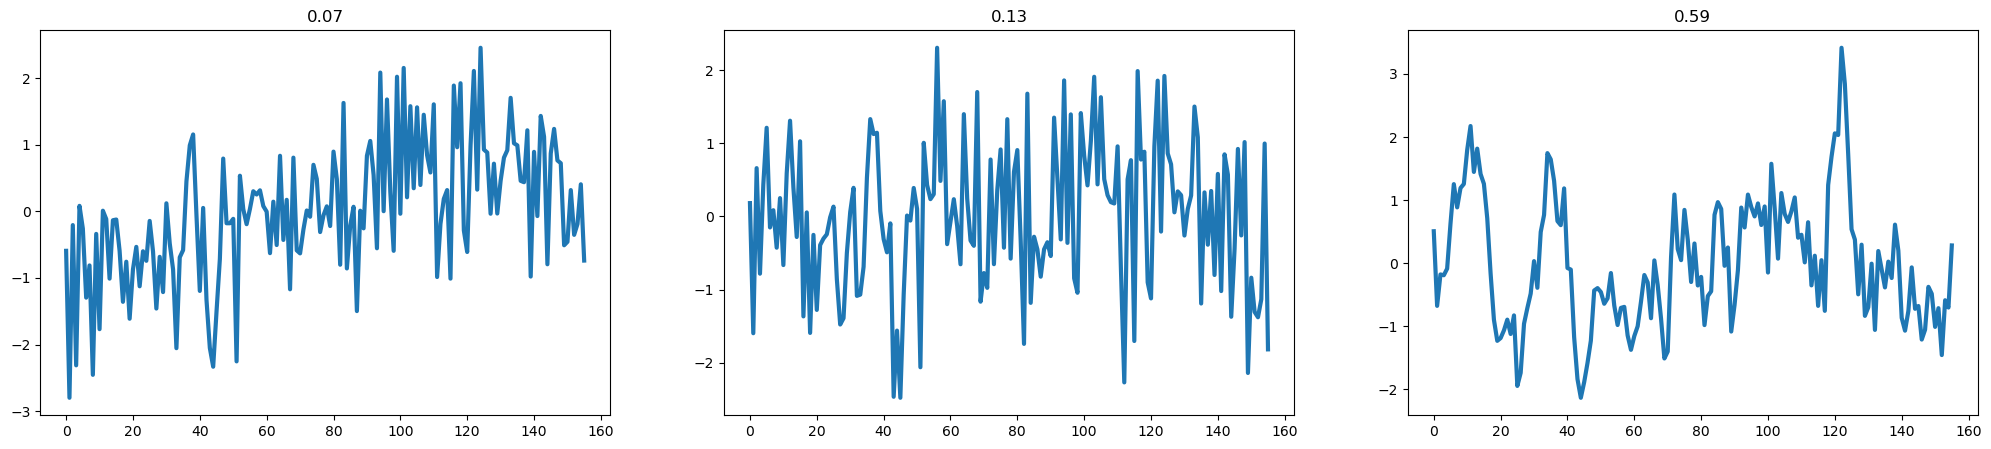

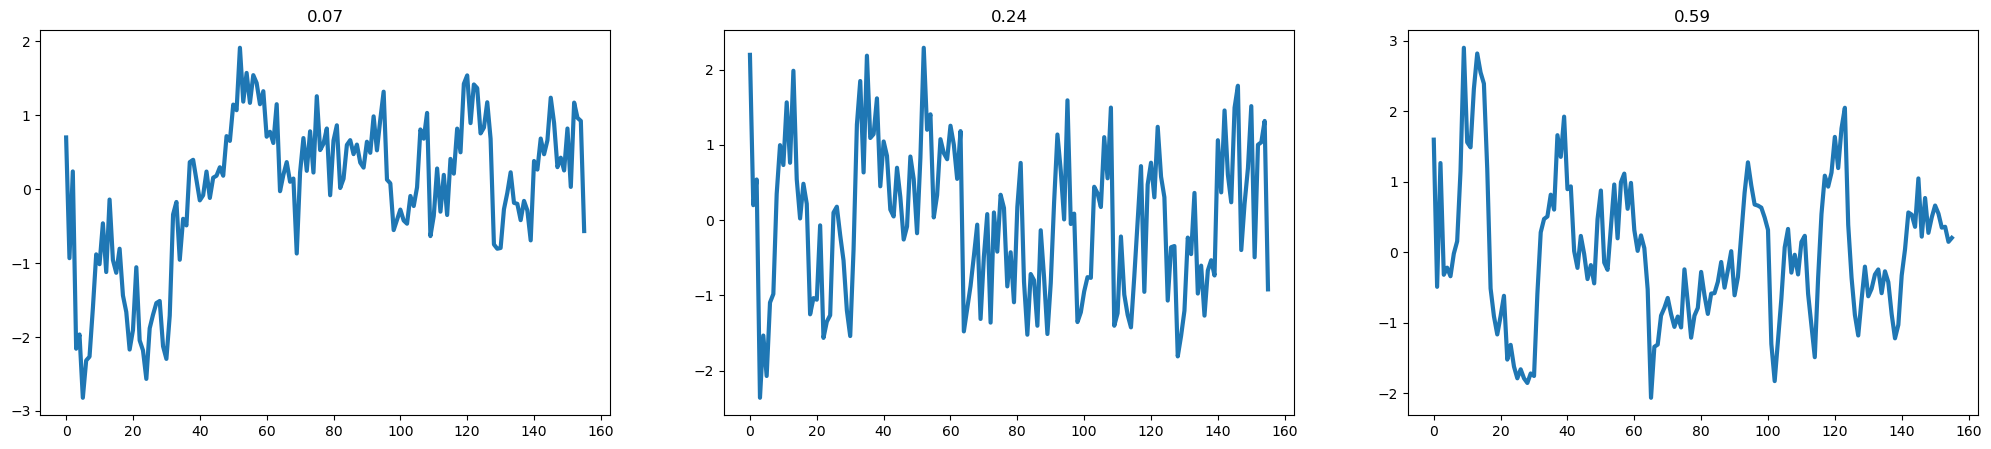

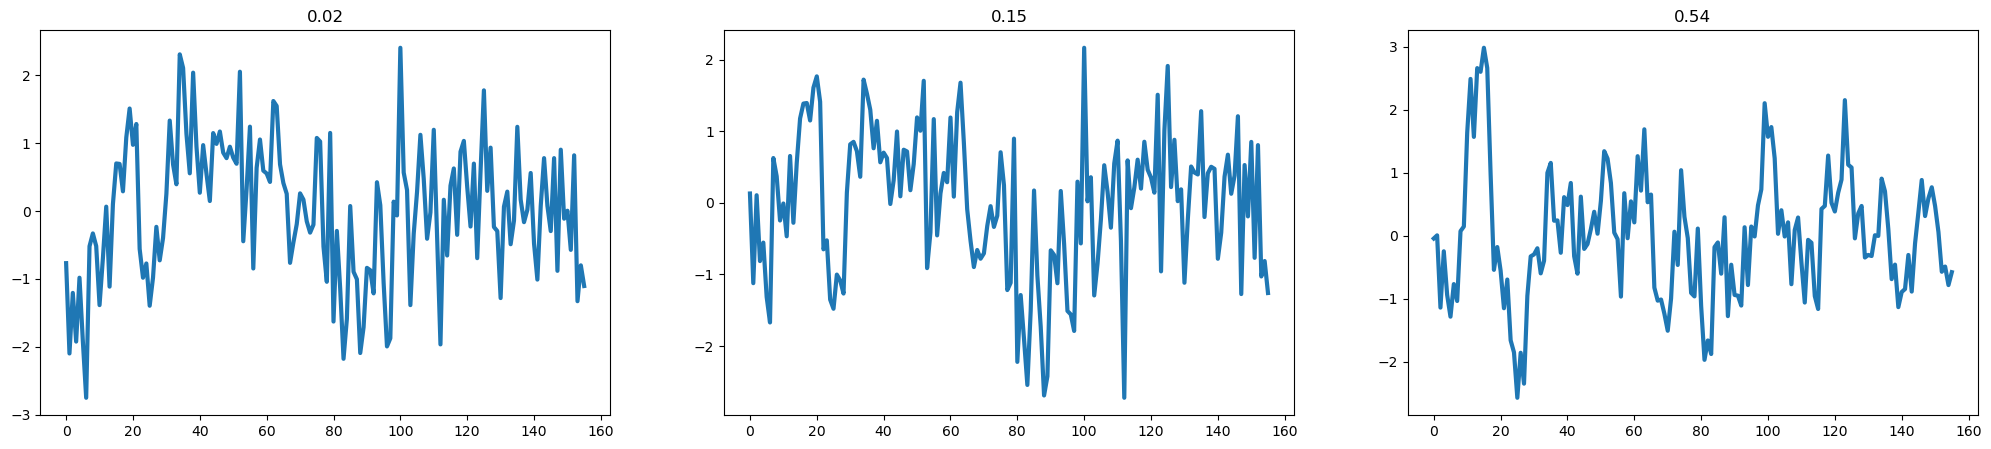

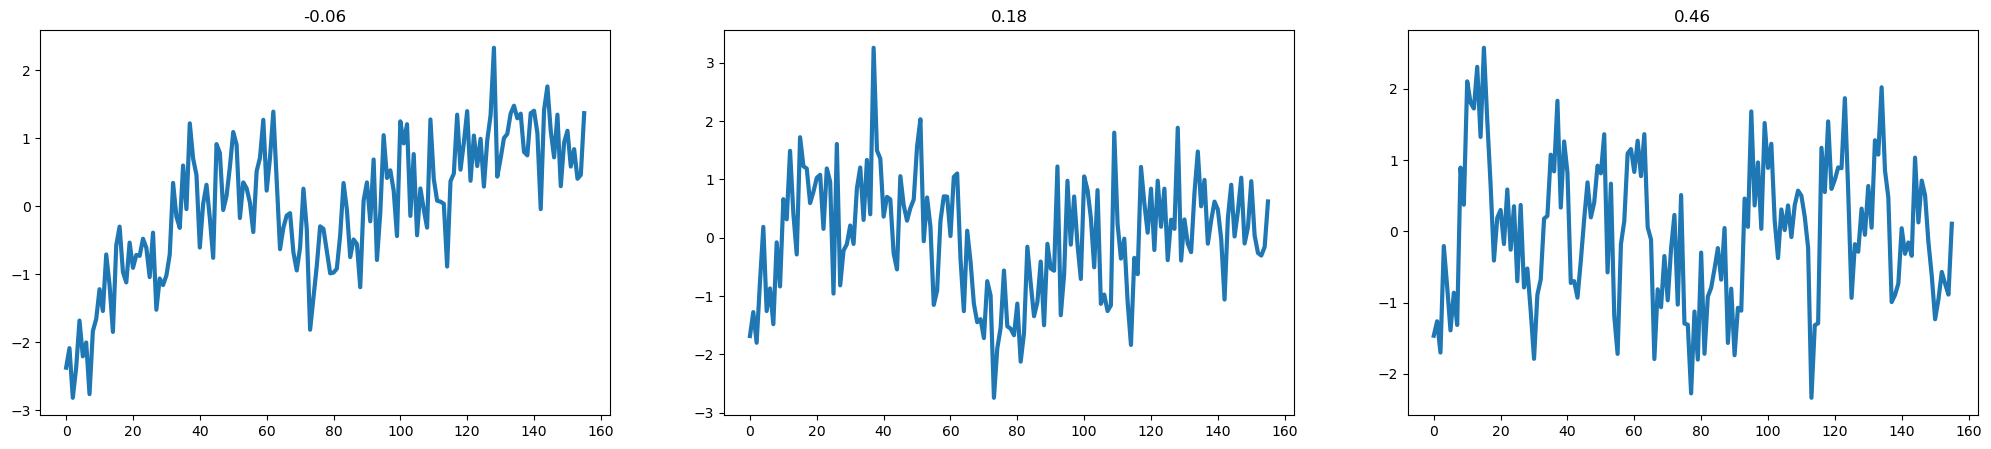

In [131]:
for idx in np.argsort(rdeepcor-rpreproc)[::-1][0:20]:
    plt.figure(figsize=(25,5))
    plt.subplot(1,3,1);plt.plot(zpreproc_series_ffa[idx,:],linewidth=3);plt.title(rpreproc[idx].round(2))
    plt.subplot(1,3,2);plt.plot(zcompcor_series_ffa[idx,:],linewidth=3);plt.title(rcompcor[idx].round(2))
    plt.subplot(1,3,3);plt.plot(zdeepcor_series_ffa[idx,:],linewidth=3);plt.title(rdeepcor[idx].round(2))

In [70]:
deepcor_vals = [0.0, 0.3, 0.1, 0.4, 0.5, 0.2, 0.7, 1.1, 0.9, 0.6, 0.4, 0.3, 0.6, 1.2, 1.8, 2.3, 2.2, 1.9, 1.4, 0.8, 0.3, -0.2, -0.5, -0.7, -0.9, -0.6, -0.4, -0.8, -1.0, -0.7, -0.3, 0.1, -0.2, -0.5, -0.9, -0.6, 0.2, 0.5, 0.8, 0.9, 0.7, 0.4, 0.6, 0.3, -0.2, -0.5, -0.7, -0.5, -0.8, -0.4, 0.0, -0.3, -0.6, -0.9, -1.2, -1.5, -1.1, -0.8, -0.5, -0.3, -0.6, -0.9, -0.7, -0.4, -0.2, -0.5, -0.8, -1.0, -1.2, -0.9, -1.1, -0.8, -0.6, -0.8, -1.0, -0.7, -0.5, -0.8, -0.6, -0.9, -0.7, -0.4, -0.6, -0.3, -0.5, -0.8, -0.6, -0.2, 0.1, 0.3, 0.5, 0.4, 0.2, -0.1, -0.3, 0.0, 0.3, 0.5, 0.7, 1.0, 1.2, 0.9, 0.6, 0.8, 1.1, 0.9, 0.5, 0.3, 0.0, -0.3, -0.5, -0.4, -0.6, -0.4, -0.2, 0.1, 0.3, 0.2, 0.5, 0.8, 1.2, 1.6, 1.9, 2.1, 2.0, 1.7, 1.4, 1.2, 0.9, 0.6, 0.3, 0.0, -0.3, -0.6, -0.8, -1.0, -0.7, -0.4, 0.0, 0.3, 0.6, 0.8, 1.0, 0.7, 0.4, 0.2, 0.5, 0.3, 0.0, -0.2, 0.1, 0.3, 0.5, 0.4, 0.2, -0.1]

In [66]:
compcor_vals = [0.6,0.6,0.6,0.596,0.5,0.55,0.377,0.482,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.555,0.609,0.555,0.555,0.546,0.55,0.546,0.418,0.299,0.418,0.459,0.454,0.436,0.413,0.372,0.477,0.646,0.541,0.637,0.618,0.582,0.546,0.555,0.55,0.55,0.546,0.546,0.546,0.555,0.546,0.546,0.546,0.6,0.641,0.573,0.664,0.614,0.591,0.546,-0.202,-0.298,-0.316,-0.348,-0.343,-0.334,-0.361,-0.357,-0.352,-0.357,-0.27,-0.252,-0.307,-0.307,-0.307,-0.357,-0.366,-0.357,-0.357,-0.375,-0.361,-0.366,-0.361,-0.357,-0.357,-0.357,-0.357,-0.266,-0.257,-0.366,-0.302,-0.302,-0.357,-0.361,-0.357,-0.357,-0.357,-0.357,-0.357,-0.366,-0.357,-0.352,-0.293,-0.32,-0.357,-0.302,-0.288,-0.366,-0.288,-0.288,-0.266,-0.343,-0.302,-0.188,0.55,0.55,0.55,0.546,0.55,0.65,0.309,0.413,0.527,0.536,0.454,0.564,0.482,0.477,0.568,0.541,0.555,0.55,0.546,0.541,0.541,0.55,0.618,0.582,0.546,0.609,0.696,0.55,0.618,0.618,0.546,0.555,0.555,0.55,0.55,0.555,0.555,0.555,0.546,0.568,0.532,0.5,0.591,0.591,0.5,0.568,0.564,0.591]
compcor_vals = np.array(compcor_vals)

In [72]:
r = [np.corrcoef(zdeepcor_series_ffa[i,:],deepcor_vals)[0,1] for i in range(zdeepcor_series_ffa.shape[0])]

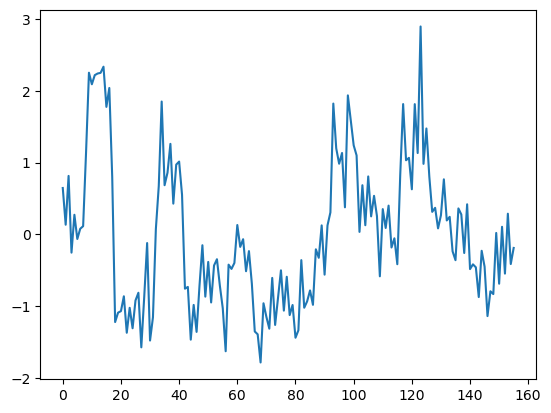

In [73]:
plt.plot(zdeepcor_series_ffa[1510,:])

<AxesSubplot:ylabel='Count'>

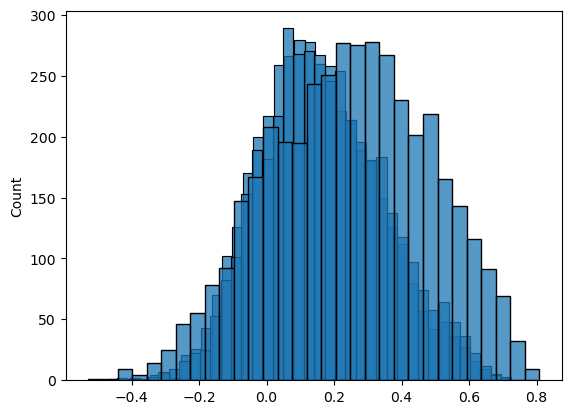

In [217]:
import seaborn as sns

sns.histplot(r1)
sns.histplot(r2)
sns.histplot(r3)

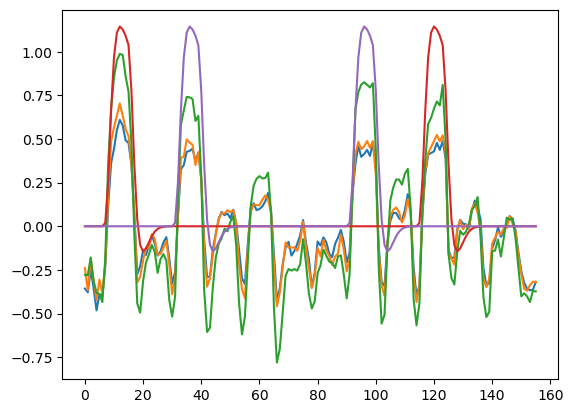

In [198]:
plt.plot(arr1)
plt.plot(arr2)
plt.plot(arr3)
plt.plot(X1['face'].values)
plt.plot(X1['body'].values)

In [37]:
fn_temp = 'contrast_face_{s}_R{r}_deepcor.nii.gz'

In [71]:
roi_fn_temp = '../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz'
res = np.zeros((len(rvec),len(subs),3))
kinds = ['preproc','compcor','deepcor']
for s in range(len(subs)):
    for r in rvec:
        for k in range(3):
            kind = kinds[k]
            im_fn = os.path.join(ofdir,'contrast_face_{s}_R{r}_{kind}.nii.gz'.format(s=s,r=r,kind=kind))
            roi_fn = roi_fn_temp.format(sub=subs[s])
            res[r-1,s,k] = get_roi_data(im_fn,roi_fn)
np.save(f'../Data/betas_forrest_face_{analysis_name}.npy',res)

In [72]:
roi_fn_temp = '../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz'
res = np.zeros((len(rvec),len(subs),3))
kinds = ['preproc','compcor','deepcor']
for s in range(len(subs)):
    for r in rvec:
        for k in range(3):
            kind = kinds[k]
            im_fn = os.path.join(ofdir,'corr2face_S{s}_R{r}_{kind}.nii.gz'.format(s=s,r=r,kind=kind))
            roi_fn = roi_fn_temp.format(sub=subs[s])
            res[r-1,s,k] = get_roi_data(im_fn,roi_fn)
np.save(f'../Data/corr2face_forrest_{analysis_name}.npy',res)

In [73]:
roi_fn_temp = '../Data/StudyForrest/ROIs/rPPA_final_mask_{sub}_bin.nii.gz'
res = np.zeros((len(rvec),len(subs),3))
kinds = ['preproc','compcor','deepcor']
for s in range(len(subs)):
    for r in rvec:
        for k in range(3):
            kind = kinds[k]
            im_fn = os.path.join(ofdir,'corr2place_S{s}_R{r}_{kind}.nii.gz'.format(s=s,r=r,kind=kind))
            roi_fn = roi_fn_temp.format(sub=subs[s])
            res[r-1,s,k] = get_roi_data(im_fn,roi_fn)
            
np.save(f'../Data/corr2place_forrest_{analysis_name}.npy',res)

In [74]:
roi_fn_temp = '../Data/StudyForrest/ROIs/rPPA_final_mask_{sub}_bin.nii.gz'
res = np.zeros((len(rvec),len(subs),3))
kinds = ['preproc','compcor','deepcor']
for s in range(len(subs)):
    for r in rvec:
        for k in range(3):
            kind = kinds[k]
            im_fn = os.path.join(ofdir,'contrast_place_S{s}_R{r}_{kind}.nii.gz'.format(s=s,r=r,kind=kind))
            roi_fn = roi_fn_temp.format(sub=subs[s])
            res[r-1,s,k] = get_roi_data(im_fn,roi_fn)
            
np.save(f'../Data/betas_forrest_place_{analysis_name}.npy',res)

In [75]:
mot = np.zeros((len(rvec),len(subs)))
for s in range(len(subs)):
    for r in rvec:
        sub = subs[s]
        conf_fn = os.path.join(indir,f'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')
        df = pd.read_csv(conf_fn,delimiter='\t')
        fd = df['FramewiseDisplacement'].values[1::]
        mot[r-1,s]=fd.mean()

np.save('../Data/mot_forrest.npy',mot)

In [86]:
# analysis_name = 'refactored-forrest-v3'
# face_beta1 = np.load(f'../Data/betas_forrest_face_{analysis_name}.npy')
# analysis_name = 'refac-baseline-forrest-v1'
# face_beta2 = np.load(f'../Data/betas_forrest_face_{analysis_name}.npy')
# analysis_name = 'refac-baseline-TC-forrest-v1'
# face_beta3 = np.load(f'../Data/betas_forrest_face_{analysis_name}.npy')

In [87]:
# face_beta1.mean(axis=0).mean(axis=0).round(2)

In [88]:
# face_beta2.mean(axis=0).mean(axis=0).round(2)

In [89]:
# face_beta3.mean(axis=0).mean(axis=0).round(2)

In [3]:
import numpy as np

In [4]:
aname='refac-baseline-forrest-v1'
fn_face = f'../Data/betas_forrest_face_{aname}.npy'
fn_place = f'../Data/betas_forrest_place_{aname}.npy'

In [8]:
a = np.load(fn_face)
a.mean(axis=0).mean(axis=0).round(4)

array([1.7928, 1.9336, 1.2275])

In [9]:
a = np.load(fn_place)
a.mean(axis=0).mean(axis=0).round(4)

array([2.1213, 2.299 , 2.5202])

In [21]:
aname='refac-baseline-forrest-v1'
fn_face = f'../Data/corr2face_forrest_{aname}.npy'
fn_place = f'../Data/corr2place_forrest_{aname}.npy'

In [28]:
a = np.load(fn_face)
a.mean(axis=0).mean(axis=0).round(4)

array([0.1422, 0.1593, 0.1561])

In [25]:
b = np.load(fn_place).mean(axis=0).mean(axis=0).round(4)

array([0.2349, 0.2517, 0.3138])